# Altair Data Server

This notebook shows an example of using the [Altair data server](https://github.com/altair-viz/altair_data_server), a lightweight plugin for [Altair](http://altair-viz.github.io) that lets you efficiently and transparently work with larger datasets.

## Installation

Altair data server is still in development, but can be installed directly from github with pip:

In [1]:
!pip install altair_data_server

## Motivation

Altair charts are built on [vega-lite](http://vega.github.io/vega-lite), a visualization grammar that encodes charts in JSON before rendering them in your browser with Javascript.

For example, consider the following chart:

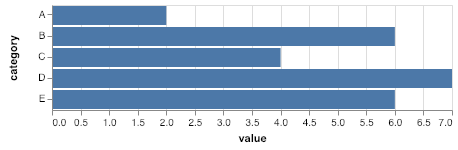

In [2]:
import pandas as pd
import numpy as np
import altair as alt

data = pd.DataFrame({
    'value': [2, 6, 4, 7, 6],
    'category': list('ABCDE'),
})

chart = alt.Chart(data).mark_bar().encode(
    x='value',
    y='category'
)

chart

The chart itself, including the data, is encoded to a JSON specification that you can inspect:

In [3]:
print(chart.to_json())

{
  "$schema": "https://vega.github.io/schema/vega-lite/v2.6.0.json",
  "config": {
    "view": {
      "height": 300,
      "width": 400
    }
  },
  "data": {
    "name": "data-ce24079b8164f6736574dbd5cd2f7d05"
  },
  "datasets": {
    "data-ce24079b8164f6736574dbd5cd2f7d05": [
      {
        "category": "A",
        "value": 2
      },
      {
        "category": "B",
        "value": 6
      },
      {
        "category": "C",
        "value": 4
      },
      {
        "category": "D",
        "value": 7
      },
      {
        "category": "E",
        "value": 6
      }
    ]
  },
  "encoding": {
    "x": {
      "field": "value",
      "type": "quantitative"
    },
    "y": {
      "field": "category",
      "type": "nominal"
    }
  },
  "mark": "bar"
}


Notice that the data is encoded in the chart specification itself: this is very convenient because it results in a single, well-defined specification that contains **everything** required to recreate the chart.

However, this leads to issues for larger datasets. For example:

In [4]:
df = pd.DataFrame({
    'timepoint': np.arange(5000),
    'value': np.random.randn(5000),
    'label': np.random.choice(list('ABCDE'), 5000)
})

chart = alt.Chart(df).mark_line().encode(
    x='timepoint',
    y='value',
    color='label'
)


def print_size_of(chart):
    spec = chart.to_json()
    print(f"Size of chart spec: {len(spec) / 1024:.1f} KB")
    
print_size_of(chart)

Size of chart spec: 500.7 KB


If we had rendered this chart, it would have resulted in about half a megabyte of JSON text being embedded into the notebook. If your notebook contains many charts, this can quickly lead to large and unwieldy notebooks, and in the worst cases to crashing the browser.

For this reason, Altair builds in a protection that prevents you from embedding extremely large data. Here's what happens when you use a dataset with a large number of rows:

In [5]:
df = pd.DataFrame({
    'x': np.arange(50000),
    'y': np.random.randn(50000),
})

big_chart = alt.Chart(df).mark_line().encode(
    x='x',
    y='y'
)

big_chart.display()

MaxRowsError: The number of rows in your dataset is greater than the maximum allowed (5000). For information on how to plot larger datasets in Altair, see the documentation

Chart({
  data:            x         y
  0          0 -0.187207
  1          1  0.236761
  2          2  0.204160
  3          3  1.510038
  4          4  0.855619
  5          5 -1.630006
  6          6 -1.017096
  7          7 -1.100416
  8          8 -2.332064
  9          9  0.979970
  10        10  1.274392
  11        11 -0.500785
  12        12 -0.567306
  13        13 -1.946447
  14        14 -0.984827
  15        15 -0.045963
  16        16  2.503872
  17        17  0.481599
  18        18  0.872812
  19        19 -0.280674
  20        20  0.587096
  21        21  0.345636
  22        22  0.226660
  23        23 -0.103801
  24        24 -1.070477
  25        25 -0.391096
  26        26  1.324717
  27        27 -2.045824
  28        28 -0.858693
  29        29 -0.024313
  ...      ...       ...
  49970  49970  1.778256
  49971  49971  0.334451
  49972  49972 -0.788223
  49973  49973 -1.012857
  49974  49974 -0.019542
  49975  49975 -1.143520
  49976  49976  1.499920
  49977  49

We can print the size of the chart by temporarily disabling the maximum rows check:

In [6]:
with alt.data_transformers.enable(max_rows=None):
    print_size_of(big_chart)

Size of chart spec: 3389.5 KB


Had Altair displayed this, it would have added  3MB of JSON text to the notebook, and if we created multiple charts, it would be another 3MB each time. This can quickly add-up in the context of interactive data exploration.

The way to get around this is to put the data somewhere that is not in the notebook itself, but is visible to the renderer running in the notebook. Altair has some [existing approaches](https://altair-viz.github.io/user_guide/faq.html#maxrowserror-how-can-i-plot-large-datasets) that work by saving the data to disk, but this is not always desirable, and doesn't always work in cloud-based Jupyter frontends.

## A Solution: Altair Data Server

The [Altair data server](https://github.com/altair-viz/altair_data_server) plugin provides a nice solution to this. Rather than embedding the data in the notebook or saving the data to disk, when enabled it starts a background server, serves the data, and inserts the appropriate URL into the altair chart:

Size of chart spec: 0.4 KB


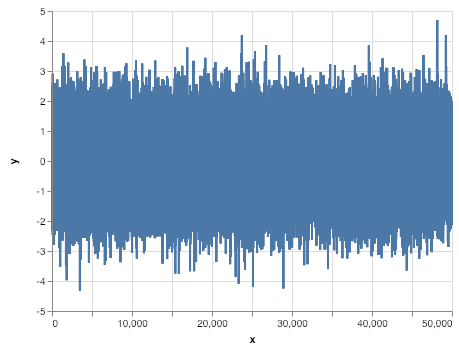

In [7]:
alt.data_transformers.enable('data_server_proxied')
print_size_of(big_chart)
big_chart.display()

The resulting spec is only 0.4KB, which is small enough that embedding it in the notebook doesn't cause problems.

It's instructive to look at the resulting spec:

In [8]:
print(big_chart.to_json())

{
  "$schema": "https://vega.github.io/schema/vega-lite/v2.6.0.json",
  "config": {
    "view": {
      "height": 300,
      "width": 400
    }
  },
  "data": {
    "url": "http://localhost:21953/ce767407-e3f3-4d15-a806-7b05a362ddb5.json"
  },
  "encoding": {
    "x": {
      "field": "x",
      "type": "quantitative"
    },
    "y": {
      "field": "y",
      "type": "quantitative"
    }
  },
  "mark": "line"
}


What the data transformer has done is to replace the embedded data with a URL reference, and to make that data available at that URL. We can see this by accessing the URL directly:

In [9]:
url = big_chart.to_dict()['data']['url']
print(url)

http://localhost:21953/ce767407-e3f3-4d15-a806-7b05a362ddb5.json


In [10]:
served_data = pd.read_json(url)
served_data.head()

,x,y
0,0,-0.187207
1,1,0.236761
2,2,0.204160
3,3,1.510038
4,4,0.855619


## When to use the data server

There is one distinct disadvantage of using the data server approach: your charts will only render as long as your Python session is active.

So the data server is a good option when you'll be **working locally, generating multiple charts as part of an exploration of data**.

But once you are finished with exploration and want to generate charts that will be fully embedded in the notebook, you can restore the default data transformer:
```python
alt.data_transformers.enable('default')
```
and carry on from there.
